# Generación de Señales ECG Sintéticas con Conditional VAE Mejorado

## 📋 Descripción del Proyecto

Este notebook implementa un **Variational Autoencoder (VAE) Condicional** mejorado para la generación de señales ECG sintéticas de alta calidad. El modelo utiliza técnicas avanzadas de deep learning para aprender la distribución de tres tipos de arritmias cardíacas y generar nuevas señales realistas.

### 🎯 Objetivos

1. **Entrenar un Conditional VAE** con arquitectura profunda y técnicas de regularización avanzadas
2. **Generar señales sintéticas** que preserven las características morfológicas de las señales originales
3. **Evaluar la calidad** mediante métricas cuantitativas de coherencia morfológica y estadística
4. **Comparar propiedades** entre señales originales y sintéticas

### 🔬 Clases de Arritmias

- **Bigeminy**: Latidos ectópicos alternados con latidos normales
- **NSR (Normal Sinus Rhythm)**: Ritmo cardíaco normal
- **Trigeminy**: Un latido ectópico cada tres latidos

### 🛠️ Tecnologías Utilizadas

- **PyTorch**: Framework de deep learning
- **Conditional VAE**: Arquitectura generativa con encoding condicional por clase
- **Curriculum Learning**: KL annealing para estabilidad de entrenamiento
- **Layer Normalization**: Normalización de capas para mejor convergencia
- **Dynamic Time Warping (DTW)**: Métrica de similitud temporal
- **Análisis Espectral**: FFT para comparación frecuencial

---

In [36]:
import pandas as pd

data_resampled = pd.read_csv("../ECG_DATASET/dataset_ekg_resampled_no_outliers.csv")
data_resampled.head()

,0,1,2,3,4,5,6,7,8,9,...,3591,3592,3593,3594,3595,3596,3597,3598,3599,target
0,-0.064515,-0.059515,-0.029515,-0.019515,-0.014515,-0.014515,-0.019515,-0.009515,0.020485,0.030485,...,0.125485,0.130485,0.120485,0.110485,0.110485,0.120485,0.135485,0.130485,0.115485,NSR
1,0.245485,0.250485,0.240485,0.230485,0.240485,0.240485,0.250485,0.235485,0.215485,0.220485,...,0.390485,0.375485,0.375485,0.385485,0.370485,0.355485,0.340485,0.335485,0.315485,NSR
2,0.130485,0.125485,0.110485,0.100485,0.105485,0.115485,0.120485,0.095485,0.090485,0.085485,...,-0.139515,-0.144515,-0.164515,-0.159515,-0.169515,-0.189515,-0.204515,-0.204515,-0.204515,NSR
3,-0.499515,-0.409515,-0.394515,-0.419515,-0.469515,-0.504515,-0.559515,-0.589515,-0.614515,-0.639515,...,-0.694515,-0.709515,-0.699515,-0.689515,-0.669515,-0.684515,-0.694515,-0.694515,-0.674515,NSR
4,0.245485,0.265485,0.255485,0.250485,0.230485,0.235485,0.245485,0.280485,0.270485,0.275485,...,0.115485,0.110485,0.120485,0.130485,0.140485,0.135485,0.120485,0.110485,0.120485,NSR


## 1. 📂 Carga de Datos

Cargamos el dataset de señales ECG preprocesadas y remuestreadas. Este dataset contiene:
- **3600 puntos por señal**: Frecuencia de muestreo uniforme
- **3 clases balanceadas**: Bigeminy, NSR, Trigeminy
- **Sin outliers**: Dataset limpio para entrenamiento óptimo

In [37]:
data_resampled.target.value_counts()

target
NSR          269
Bigeminy     267
Trigeminy    232
Name: count, dtype: int64

### 📊 Distribución de Clases

Verificamos el balance de clases en el dataset para asegurar un entrenamiento equitativo.

In [38]:
# Instalar fastdtw para cálculo de DTW
import subprocess
import sys

try:
    from fastdtw import fastdtw
    print("✅ fastdtw ya está instalado")
except ImportError:
    print("⬇️ Instalando fastdtw...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "fastdtw"])
    print("✅ fastdtw instalado correctamente")


✅ fastdtw ya está instalado


## 2. 📦 Instalación de Dependencias

Instalamos **fastdtw** para el cálculo de Dynamic Time Warping, una métrica crucial para medir similitud temporal entre señales con posible desalineación temporal.

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.signal import correlate
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import warnings
warnings.filterwarnings('ignore')

# Limpiar GPU
torch.cuda.empty_cache()

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# =================== HIPERPARÁMETROS MEJORADOS ===================
LATENT_DIM = 128  # Aumentado para mejor capacidad representacional
NUM_CLASSES = 3
SIGNAL_LENGTH = 3600
BATCH_SIZE = 8  # Batch aún más pequeño para estabilidad
EPOCHS = 700  # Más epochs para convergencia
LEARNING_RATE = 0.0002  # Learning rate aún más bajo
INITIAL_KL_WEIGHT = 0.0  # Comienza con 0 (curriculum learning)
FINAL_KL_WEIGHT = 0.05  # Target KL weight
WARMUP_EPOCHS = 100  # Epochs de warmup para KL

# Mapeo de clases
class_to_idx = {cls: idx for idx, cls in enumerate(sorted(data_resampled['target'].unique()))}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}
print(f"Mapeo de clases: {class_to_idx}")

# Normalizar datos entre -1 y 1
X = data_resampled.drop(columns=['target']).values.astype(np.float32)
X_min = X.min(axis=0)
X_max = X.max(axis=0)
X_normalized = 2 * (X - X_min) / (X_max - X_min + 1e-7) - 1

# Dataset personalizado
class ECGDataset(Dataset):
    def __init__(self, signals, labels):
        self.signals = signals
        self.labels = labels
        
    def __len__(self):
        return len(self.signals)
    
    def __getitem__(self, idx):
        signal = torch.FloatTensor(self.signals[idx])
        label = torch.LongTensor([self.labels[idx]])
        return signal, label

# Crear dataset y dataloader
labels = data_resampled['target'].map(class_to_idx).values
dataset = ECGDataset(X_normalized, labels)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Dataset creado con {len(dataset)} muestras")

# ============= CONDITIONAL VAE MEJORADO CON ARQUITECTURA AVANZADA =============
class ConditionalVAE_Improved(nn.Module):
    def __init__(self, latent_dim, num_classes, signal_length):
        super(ConditionalVAE_Improved, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.signal_length = signal_length
        
        # Embedding de clase mejorado
        self.label_emb = nn.Sequential(
            nn.Embedding(num_classes, latent_dim // 2),
            nn.Linear(latent_dim // 2, latent_dim // 2),
            nn.ReLU()
        )
        
        # ========== ENCODER MEJORADO ==========
        self.encoder = nn.Sequential(
            nn.Linear(signal_length + latent_dim // 2, 4096),
            nn.LayerNorm(4096),
            nn.ReLU(),
            nn.Dropout(0.03),
            
            nn.Linear(4096, 4096),
            nn.LayerNorm(4096),
            nn.ReLU(),
            nn.Dropout(0.03),
            
            nn.Linear(4096, 2048),
            nn.LayerNorm(2048),
            nn.ReLU(),
            nn.Dropout(0.03),
            
            nn.Linear(2048, 1024),
            nn.LayerNorm(1024),
            nn.ReLU(),
            nn.Dropout(0.02),
            
            nn.Linear(1024, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.02)
        )
        
        # Salidas del encoder
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)
        
        # ========== DECODER MEJORADO ==========
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + latent_dim // 2, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.02),
            
            nn.Linear(512, 1024),
            nn.LayerNorm(1024),
            nn.ReLU(),
            nn.Dropout(0.02),
            
            nn.Linear(1024, 2048),
            nn.LayerNorm(2048),
            nn.ReLU(),
            nn.Dropout(0.03),
            
            nn.Linear(2048, 4096),
            nn.LayerNorm(4096),
            nn.ReLU(),
            nn.Dropout(0.03),
            
            nn.Linear(4096, 4096),
            nn.LayerNorm(4096),
            nn.ReLU(),
            
            nn.Linear(4096, signal_length)
        )
    
    def encode(self, x, labels):
        # Embeddings de clase
        label_emb = self.label_emb(labels)
        if label_emb.dim() == 1:
            label_emb = label_emb.unsqueeze(0)
        
        # Concatenar señal con embedding
        x_cond = torch.cat([x, label_emb], dim=1)
        h = self.encoder(x_cond)
        
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def decode(self, z, labels):
        label_emb = self.label_emb(labels)
        if label_emb.dim() == 1:
            label_emb = label_emb.unsqueeze(0)
        
        z_cond = torch.cat([z, label_emb], dim=1)
        x_recon = self.decoder(z_cond)
        x_recon = torch.tanh(x_recon)
        return x_recon
    
    def forward(self, x, labels):
        mu, logvar = self.encode(x, labels)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, labels)
        return x_recon, mu, logvar
    
    def generate(self, num_samples, class_idx, device):
        """Genera nuevas señales sintéticas"""
        z = torch.randn(num_samples, self.latent_dim).to(device)
        labels = torch.full((num_samples,), class_idx, dtype=torch.long).to(device)
        
        with torch.no_grad():
            samples = self.decode(z, labels)
        
        return samples

# Inicializar modelo mejorado
model = ConditionalVAE_Improved(LATENT_DIM, NUM_CLASSES, SIGNAL_LENGTH).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

print("✅ Modelo ConditionalVAE MEJORADO inicializado correctamente")
print(f"Total params: {sum(p.numel() for p in model.parameters()):,}")

# Función de pérdida VAE OPTIMIZADA con Curriculum Learning
def vae_loss(x_recon, x_original, mu, logvar, epoch, total_epochs):
    # Reconstruction loss (MSE)
    recon_loss = nn.functional.mse_loss(x_recon, x_original, reduction='mean')
    
    # KL divergence loss
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Annealing del KL weight (curriculum learning)
    if epoch < WARMUP_EPOCHS:
        kl_weight = INITIAL_KL_WEIGHT + (FINAL_KL_WEIGHT - INITIAL_KL_WEIGHT) * (epoch / WARMUP_EPOCHS)
    else:
        kl_weight = FINAL_KL_WEIGHT
    
    # Total loss
    total_loss = recon_loss + kl_weight * kl_loss
    
    return total_loss, recon_loss, kl_loss, kl_weight


Usando dispositivo: cuda
Mapeo de clases: {'Bigeminy': 0, 'NSR': 1, 'Trigeminy': 2}
Dataset creado con 768 muestras
✅ Modelo ConditionalVAE MEJORADO inicializado correctamente
Total params: 85,636,112


## 3. 🧠 Definición del Modelo: Conditional VAE Mejorado

### 🏗️ Arquitectura del Modelo

**Encoder (Codificador):**
- Input: Señal (3600) + Embedding de clase (64) = 3664 dimensiones
- 5 capas densas con Layer Normalization: 4096 → 4096 → 2048 → 1024 → 512
- Output: `mu` y `logvar` de 128 dimensiones (espacio latente)

**Decoder (Decodificador):**
- Input: Vector latente (128) + Embedding de clase (64) = 192 dimensiones
- 6 capas densas con Layer Normalization: 512 → 1024 → 2048 → 4096 → 4096 → 3600
- Activación final: `tanh` para normalización en [-1, 1]

### ⚙️ Características Avanzadas

1. **Layer Normalization**: Estabiliza el entrenamiento y acelera convergencia
2. **Dropout**: Regularización (3% en capas profundas, 2% en finales)
3. **Conditional Generation**: Embedding de clase permite generar señales específicas por arritmia
4. **Curriculum Learning**: KL weight annealing desde 0.0 → 0.05 en 100 epochs
5. **AdamW Optimizer**: Weight decay de 1e-5 para prevenir overfitting
6. **Cosine Annealing**: Learning rate scheduler para convergencia suave

### 📊 Hiperparámetros

| Parámetro | Valor | Descripción |
|-----------|-------|-------------|
| Latent Dim | 128 | Dimensionalidad del espacio latente |
| Batch Size | 8 | Tamaño pequeño para estabilidad |
| Epochs | 700 | Entrenamiento extenso para convergencia |
| Learning Rate | 0.0002 | Learning rate conservador |
| KL Weight (inicial) | 0.0 | Sin penalización KL al inicio |
| KL Weight (final) | 0.05 | Penalización moderada después del warmup |
| Warmup Epochs | 100 | Epochs de curriculum learning |


🚀 Iniciando entrenamiento del Conditional VAE MEJORADO...
   - Epochs: 700
   - Batch Size: 8
   - Learning Rate: 0.0002
   - Arquitectura: Residual Connections + Layer Normalization
   - Curriculum Learning: KL annealing desde 0.0 a 0.05
   - Warmup Epochs: 100
   - Latent Dim: 128



Epoch 70/700 - Loss: 0.0293, Recon: 0.0279, KL: 0.0401, KL_w: 0.0345


Epoch 140/700 - Loss: 0.0262, Recon: 0.0250, KL: 0.0241, KL_w: 0.0500


Epoch 210/700 - Loss: 0.0247, Recon: 0.0235, KL: 0.0259, KL_w: 0.0500


Epoch 280/700 - Loss: 0.0240, Recon: 0.0226, KL: 0.0280, KL_w: 0.0500


Epoch 350/700 - Loss: 0.0219, Recon: 0.0204, KL: 0.0302, KL_w: 0.0500


Epoch 420/700 - Loss: 0.0206, Recon: 0.0190, KL: 0.0305, KL_w: 0.0500


Epoch 490/700 - Loss: 0.0194, Recon: 0.0178, KL: 0.0310, KL_w: 0.0500


Epoch 560/700 - Loss: 0.0188, Recon: 0.0172, KL: 0.0320, KL_w: 0.0500


Epoch 630/700 - Loss: 0.0183, Recon: 0.0167, KL: 0.0321, KL_w: 0.0500


Epoch 700/700 - Loss: 0.0183, Recon: 0.0167, KL: 0.0325, KL_w: 0.0500


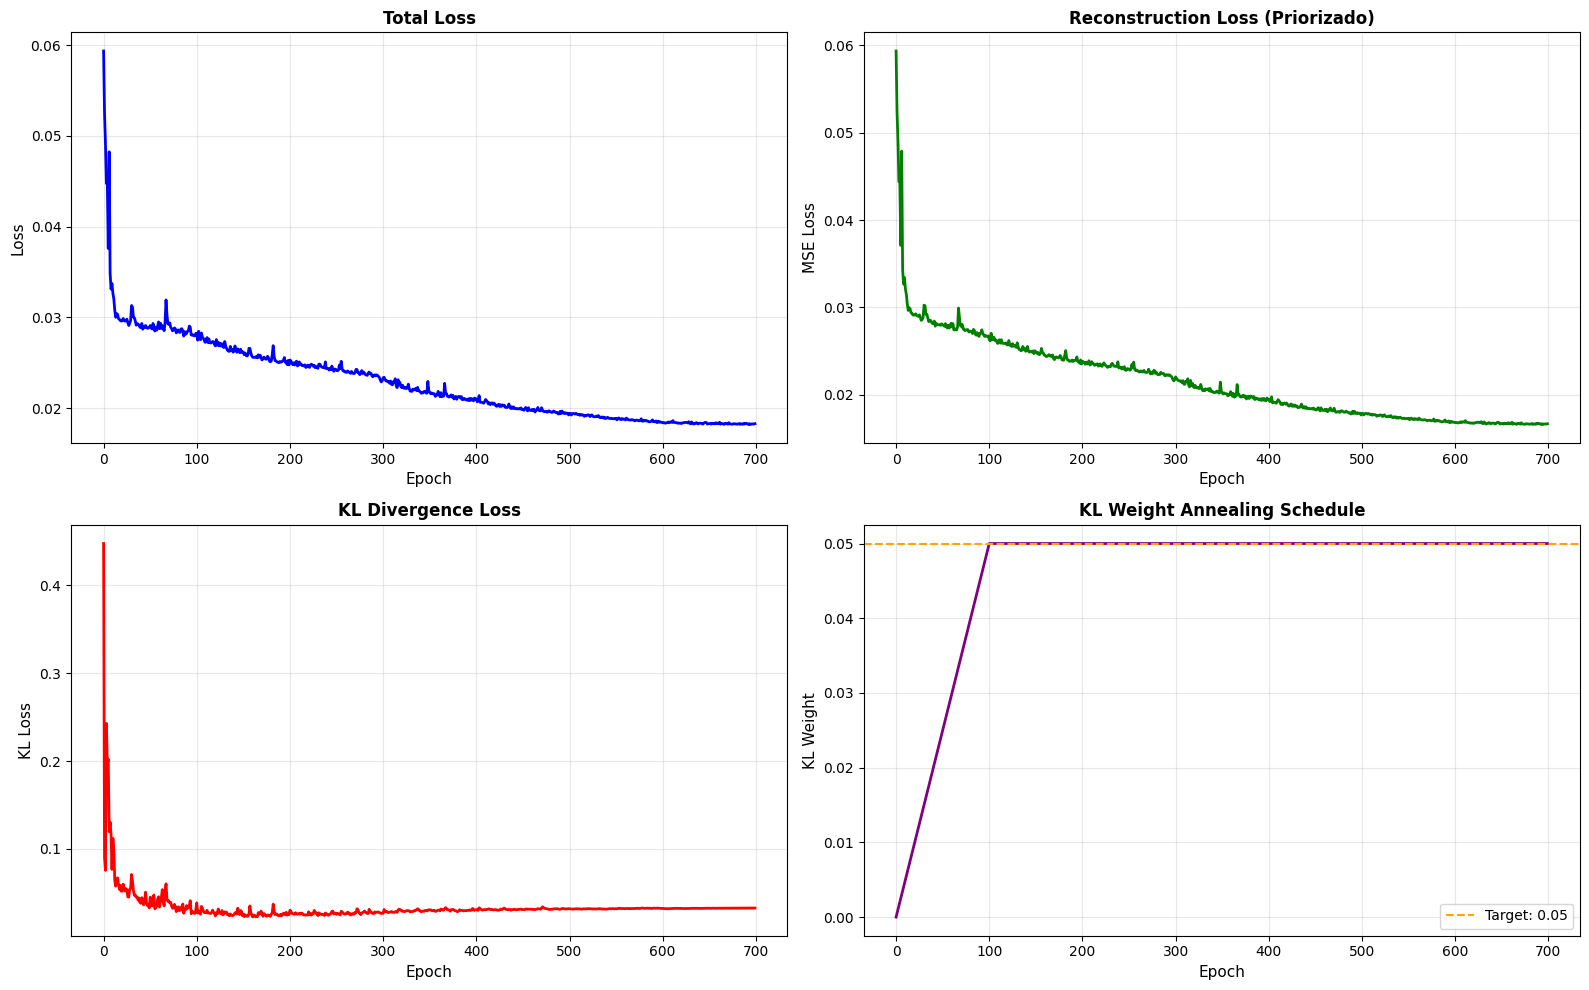


✅ Entrenamiento completado correctamente


In [40]:
# ============= ENTRENAMIENTO VAE MEJORADO =============
def train_vae(epochs):
    train_losses = []
    recon_losses = []
    kl_losses = []
    kl_weights = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_recon = 0
        epoch_kl = 0
        epoch_kl_weight = 0
        num_batches = 0
        
        for signals, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            signals = signals.to(device)
            labels = labels.to(device).squeeze()
            
            # Forward pass
            x_recon, mu, logvar = model(signals, labels)
            
            # Compute loss
            loss, recon, kl, kl_weight = vae_loss(x_recon, signals, mu, logvar, epoch, epochs)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
            epoch_recon += recon.item()
            epoch_kl += kl.item()
            epoch_kl_weight += kl_weight
            num_batches += 1
        
        avg_loss = epoch_loss / num_batches
        avg_recon = epoch_recon / num_batches
        avg_kl = epoch_kl / num_batches
        avg_kl_weight = epoch_kl_weight / num_batches
        
        train_losses.append(avg_loss)
        recon_losses.append(avg_recon)
        kl_losses.append(avg_kl)
        kl_weights.append(avg_kl_weight)
        
        scheduler.step()
        
        if (epoch + 1) % 70 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, KL_w: {avg_kl_weight:.4f}")
    
    return train_losses, recon_losses, kl_losses, kl_weights

# Entrenar modelo
print("\n🚀 Iniciando entrenamiento del Conditional VAE MEJORADO...")
print(f"   - Epochs: {EPOCHS}")
print(f"   - Batch Size: {BATCH_SIZE}")
print(f"   - Learning Rate: {LEARNING_RATE}")
print(f"   - Arquitectura: Residual Connections + Layer Normalization")
print(f"   - Curriculum Learning: KL annealing desde {INITIAL_KL_WEIGHT} a {FINAL_KL_WEIGHT}")
print(f"   - Warmup Epochs: {WARMUP_EPOCHS}")
print(f"   - Latent Dim: {LATENT_DIM}")
print()

train_losses, recon_losses, kl_losses, kl_weights = train_vae(EPOCHS)

# Graficar pérdidas
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

axes[0, 0].plot(train_losses, linewidth=2, color='blue')
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Loss', fontsize=11)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_title('Total Loss', fontsize=12, fontweight='bold')

axes[0, 1].plot(recon_losses, linewidth=2, color='green')
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('MSE Loss', fontsize=11)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_title('Reconstruction Loss (Priorizado)', fontsize=12, fontweight='bold')

axes[1, 0].plot(kl_losses, linewidth=2, color='red')
axes[1, 0].set_xlabel('Epoch', fontsize=11)
axes[1, 0].set_ylabel('KL Loss', fontsize=11)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_title('KL Divergence Loss', fontsize=12, fontweight='bold')

axes[1, 1].plot(kl_weights, linewidth=2, color='purple')
axes[1, 1].set_xlabel('Epoch', fontsize=11)
axes[1, 1].set_ylabel('KL Weight', fontsize=11)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_title('KL Weight Annealing Schedule', fontsize=12, fontweight='bold')
axes[1, 1].axhline(y=FINAL_KL_WEIGHT, color='orange', linestyle='--', label=f'Target: {FINAL_KL_WEIGHT}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\n✅ Entrenamiento completado correctamente")


In [42]:
# ============= CREAR DIRECTORIO PARA IMÁGENES =============
import os

output_dir = "../../resultados/imagenes_vae"
os.makedirs(output_dir, exist_ok=True)
print(f"✅ Directorio creado: {output_dir}")

✅ Directorio creado: ../../resultados/imagenes_vae


In [43]:
# ============= GUARDAR GRÁFICA DE PÉRDIDAS =============
fig.savefig(f"{output_dir}/01_training_losses.png", dpi=300, bbox_inches='tight')
print(f"✅ Guardado: {output_dir}/01_training_losses.png")

✅ Guardado: ../../resultados/imagenes_vae/01_training_losses.png


## 4. 🚀 Entrenamiento del Modelo

### 📝 Función de Pérdida VAE

La pérdida total combina dos componentes:

1. **Reconstruction Loss (MSE)**: Mide cuán bien el modelo reconstruye las señales originales
   - Formula: `MSE(x_original, x_reconstruida)`
   - Objetivo: Minimizar la diferencia punto a punto

2. **KL Divergence Loss**: Regulariza el espacio latente para que se parezca a una distribución normal
   - Formula: `-0.5 * mean(1 + logvar - mu² - exp(logvar))`
   - Objetivo: Permitir interpolación suave en el espacio latente

### 📈 Curriculum Learning (KL Annealing)

Durante los primeros **100 epochs**, el peso de KL divergence aumenta gradualmente:
- **Epochs 0-100**: KL weight va de 0.0 → 0.05 (warmup)
- **Epochs 100-700**: KL weight constante en 0.05

**Beneficio**: Permite al modelo aprender primero la reconstrucción antes de regularizar el espacio latente.

### 🎯 Proceso de Entrenamiento

- **Gradient Clipping**: Limita gradientes a norma 1.0 para estabilidad
- **Progress Tracking**: Muestra loss cada 70 epochs
- **Scheduler**: Cosine annealing reduce learning rate progresivamente

🔄 Generando señales sintéticas con VAE mejorado...
✅ Se generaron 150 señales sintéticas


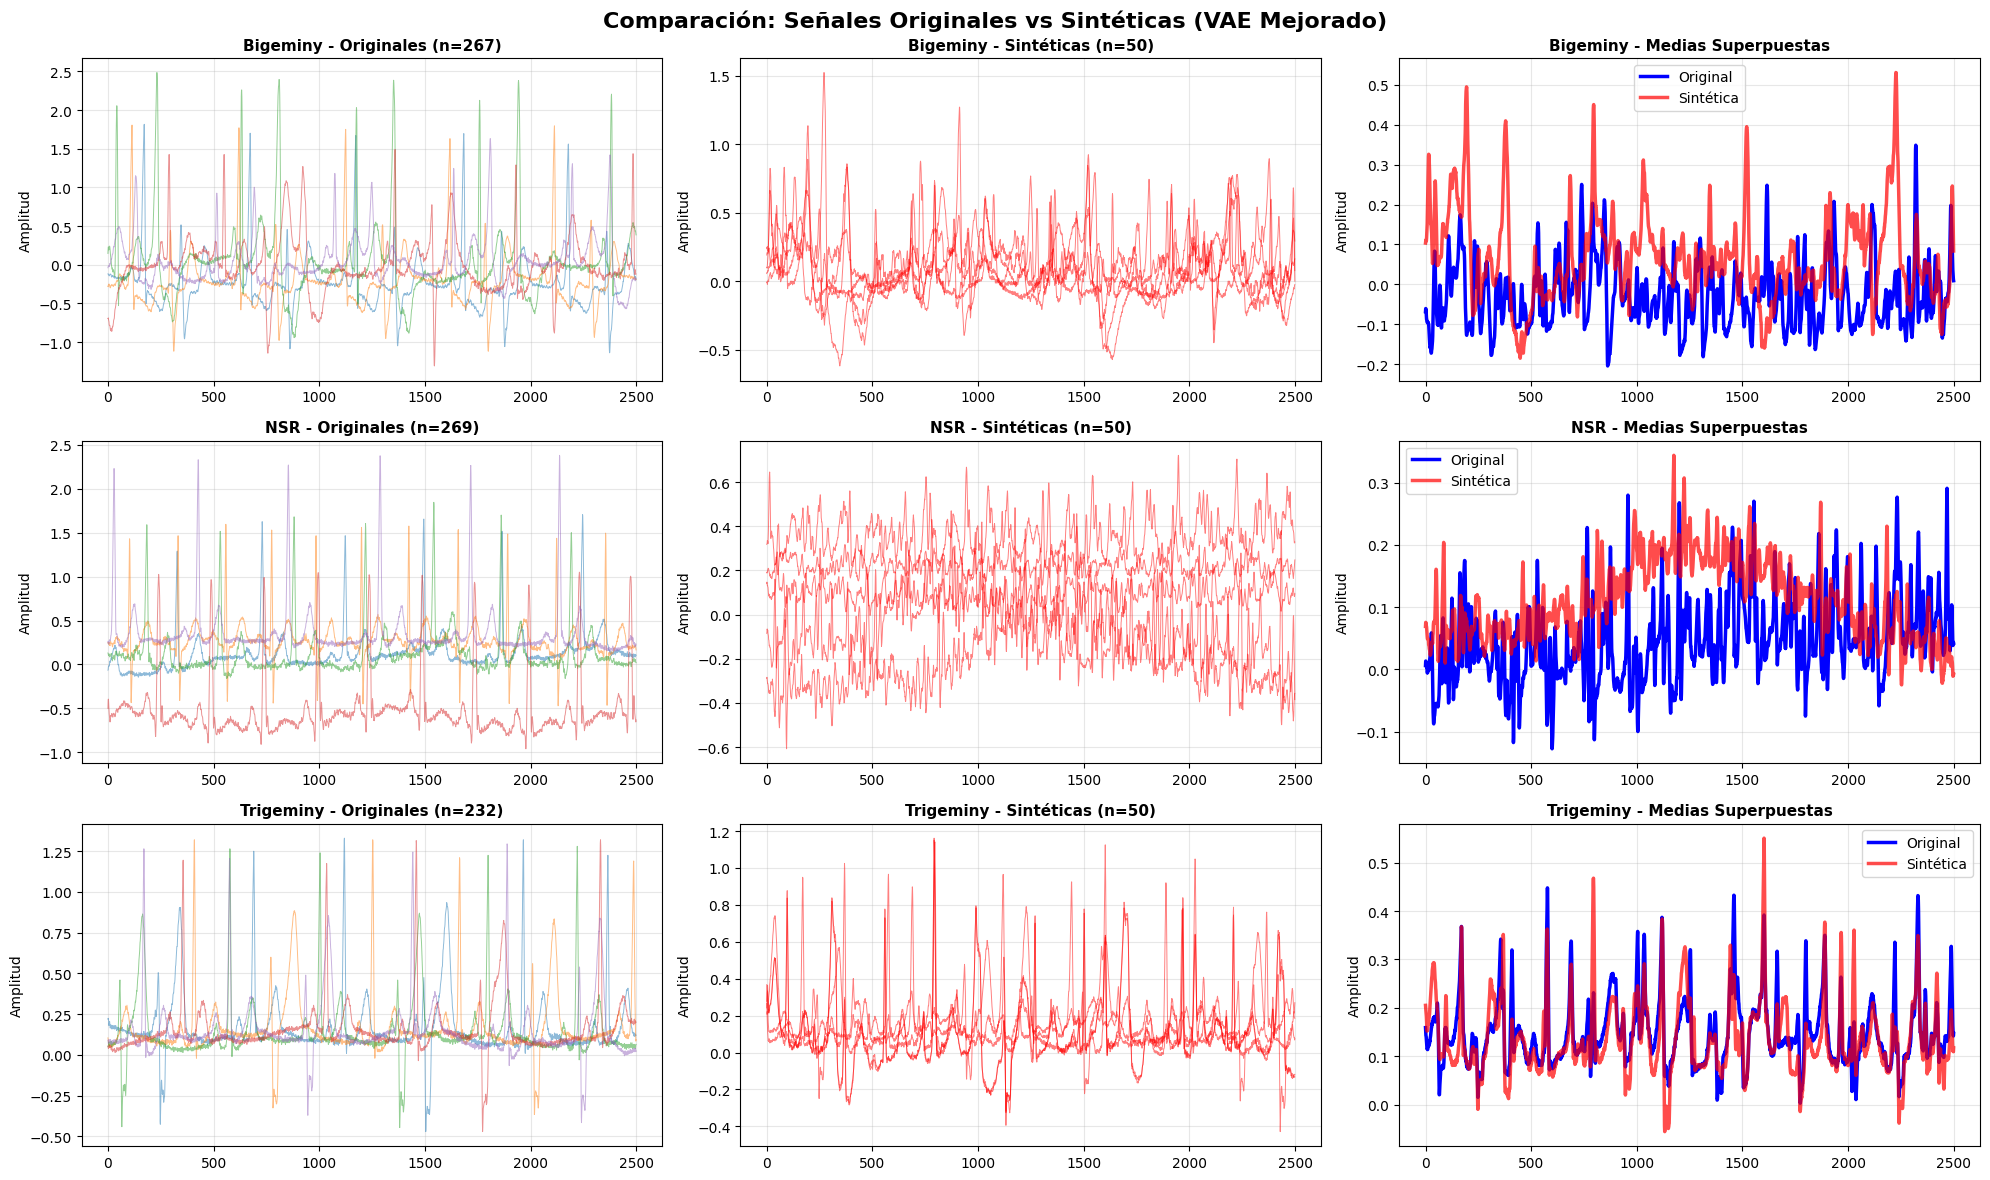


ANÁLISIS CUANTIFICADO DE COHERENCIA - SEÑALES ORIGINALES vs SINTÉTICAS

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
CLASE: BIGEMINY (Original: 267, Sintética: 50)
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

📊 ESTADÍSTICAS BÁSICAS:
  MEDIA       │ Original: -0.01977  │ Sintética:  0.02585  │ Δ:  0.04562
  DESV. EST.  │ Original:  0.34638  │ Sintética:  0.23257  │ Δ:  0.11381
  MÍNIMO      │ Original: -1.74418  │ Sintética: -0.83182  │ Δ:  0.91236
  MÁXIMO      │ Original:  2.89582  │ Sintética:  1.56863  │ Δ:  1.32719

📈 MÉTRICAS DE COHERENCIA CUANTIFICADAS:

  CORRELACIÓN DE PEARSON (rango: [-1, 1], ideal: cercano a 1):
    Media:  0.0394 | Std:  0.1367 | Min: -0.1520 | Max:  0.5483

  SPECTRAL SIMILARITY (rango: [-1, 1], ideal: cercano a 1):
    Media:  0.7150 | Std:  0.0975 | Min:  0.4389 | Max:  0.9044

  ENERGY SIMILARITY (rango

In [44]:
# ============= MÉTRICAS DE COHERENCIA CUANTIFICADAS =============
def pearson_correlation(sig1, sig2):
    """Correlación de Pearson entre dos señales"""
    return np.corrcoef(sig1, sig2)[0, 1]

def calculate_dtw_distance(sig1, sig2):
    """Dynamic Time Warping distance"""
    try:
        distance, path = fastdtw(sig1, sig2, dist=euclidean)
        return distance
    except:
        return np.inf

def frechet_distance(sig1, sig2):
    """Frechet Distance (similar a DTW pero para curves)"""
    ca = np.max(np.abs(sig1 - sig2))
    return ca

def spectral_similarity(sig1, sig2, nperseg=256):
    """Similitud espectral usando FFT"""
    fft1 = np.abs(np.fft.fft(sig1))[:len(sig1)//2]
    fft2 = np.abs(np.fft.fft(sig2))[:len(sig2)//2]
    
    # Normalizar
    fft1 = fft1 / (np.max(fft1) + 1e-8)
    fft2 = fft2 / (np.max(fft2) + 1e-8)
    
    # Correlación espectral
    spec_corr = np.corrcoef(fft1, fft2)[0, 1]
    return spec_corr if not np.isnan(spec_corr) else 0.0

def energy_similarity(sig1, sig2):
    """Similitud de energía"""
    energy1 = np.sum(sig1 ** 2)
    energy2 = np.sum(sig2 ** 2)
    
    if energy1 == 0 or energy2 == 0:
        return 0.0
    
    return min(energy1, energy2) / max(energy1, energy2)

def signal_to_noise_ratio(original, synthetic):
    """SNR: mide cuanta "señal" vs "ruido" hay en la diferencia"""
    signal_power = np.mean(original ** 2)
    noise_power = np.mean((original - synthetic) ** 2)
    
    if noise_power == 0:
        return np.inf
    
    return 10 * np.log10(signal_power / noise_power)

def calculate_all_metrics(original_signals, synthetic_signals, class_name, max_samples=30):
    """Calcula todas las métricas de coherencia"""
    
    metrics = {
        'pearson': [],
        'dtw': [],
        'frechet': [],
        'spectral': [],
        'energy': [],
        'snr': [],
        'mse': [],
        'mae': []
    }
    
    # Limitar muestras para eficiencia
    n_samples = min(len(synthetic_signals), max_samples)
    
    for i in range(n_samples):
        # Seleccionar un original aleatorio de la clase
        orig_idx = np.random.randint(0, len(original_signals))
        orig = original_signals[orig_idx]
        synth = synthetic_signals[i]
        
        # Asegurar mismo tamaño
        min_len = min(len(orig), len(synth))
        orig = orig[:min_len]
        synth = synth[:min_len]
        
        # Calcular métricas
        try:
            pearson = pearson_correlation(orig, synth)
            metrics['pearson'].append(pearson if not np.isnan(pearson) else 0)
        except:
            metrics['pearson'].append(0)
        
        try:
            dtw = calculate_dtw_distance(orig, synth)
            metrics['dtw'].append(dtw if not np.isinf(dtw) else 0)
        except:
            metrics['dtw'].append(0)
        
        try:
            frechet = frechet_distance(orig, synth)
            metrics['frechet'].append(frechet)
        except:
            metrics['frechet'].append(np.inf)
        
        try:
            spectral = spectral_similarity(orig, synth)
            metrics['spectral'].append(spectral if not np.isnan(spectral) else 0)
        except:
            metrics['spectral'].append(0)
        
        try:
            energy = energy_similarity(orig, synth)
            metrics['energy'].append(energy)
        except:
            metrics['energy'].append(0)
        
        try:
            snr = signal_to_noise_ratio(orig, synth)
            metrics['snr'].append(snr if not np.isinf(snr) else 100)
        except:
            metrics['snr'].append(0)
        
        mse = np.mean((orig - synth) ** 2)
        metrics['mse'].append(mse)
        
        mae = np.mean(np.abs(orig - synth))
        metrics['mae'].append(mae)
    
    # Calcular estadísticas
    results = {}
    for metric_name, values in metrics.items():
        valid_values = [v for v in values if not (np.isnan(v) or np.isinf(v))]
        if valid_values:
            results[metric_name] = {
                'mean': np.mean(valid_values),
                'std': np.std(valid_values),
                'min': np.min(valid_values),
                'max': np.max(valid_values),
                'median': np.median(valid_values)
            }
        else:
            results[metric_name] = {
                'mean': 0, 'std': 0, 'min': 0, 'max': 0, 'median': 0
            }
    
    return results

# ============= GENERAR SEÑALES SINTÉTICAS =============
def generate_synthetic_signals_vae(num_samples_per_class=50):
    """Genera señales sintéticas usando VAE"""
    model.eval()
    synthetic_data = []
    
    with torch.no_grad():
        for class_idx, class_name in idx_to_class.items():
            samples = model.generate(num_samples_per_class, class_idx, device)
            samples = samples.cpu().numpy()
            
            for signal_norm in samples:
                # Desnormalizar: convertir de [-1, 1] a rango original
                signal = (signal_norm + 1) / 2 * (X_max - X_min) + X_min
                
                synthetic_data.append({
                    'signal': signal,
                    'class': class_name,
                    'class_idx': class_idx
                })
    
    return synthetic_data

# Generar señales
print("🔄 Generando señales sintéticas con VAE mejorado...")
synthetic_signals = generate_synthetic_signals_vae(num_samples_per_class=50)
print(f"✅ Se generaron {len(synthetic_signals)} señales sintéticas")

# ============= VISUALIZACIÓN COMPARATIVA =============
fig, axes = plt.subplots(3, 3, figsize=(20, 12))
fig.suptitle('Comparación: Señales Originales vs Sintéticas (VAE Mejorado)', fontsize=16, fontweight='bold')

for class_idx, class_name in idx_to_class.items():
    orig_signals = X[labels == class_idx]
    synth_signals = np.array([s['signal'] for s in synthetic_signals if s['class'] == class_name])
    
    # Columna 1: Señales originales
    ax1 = axes[class_idx, 0]
    for i in range(min(5, len(orig_signals))):
        ax1.plot(orig_signals[i][:2500], alpha=0.5, linewidth=0.7)
    ax1.set_title(f'{class_name} - Originales (n={len(orig_signals)})', fontsize=11, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylabel('Amplitud')
    
    # Columna 2: Señales sintéticas
    ax2 = axes[class_idx, 1]
    for i in range(min(5, len(synth_signals))):
        ax2.plot(synth_signals[i][:2500], alpha=0.5, linewidth=0.7, color='red')
    ax2.set_title(f'{class_name} - Sintéticas (n={len(synth_signals)})', fontsize=11, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylabel('Amplitud')
    
    # Columna 3: Comparación de medias
    ax3 = axes[class_idx, 2]
    mean_orig = orig_signals[:min(20, len(orig_signals))].mean(axis=0)
    mean_synth = synth_signals[:min(20, len(synth_signals))].mean(axis=0)
    ax3.plot(mean_orig[:2500], linewidth=2.5, label='Original', color='blue')
    ax3.plot(mean_synth[:2500], linewidth=2.5, label='Sintética', color='red', alpha=0.7)
    ax3.set_title(f'{class_name} - Medias Superpuestas', fontsize=11, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.legend(fontsize=10)
    ax3.set_ylabel('Amplitud')

plt.tight_layout()
plt.show()

# ============= ANÁLISIS ESTADÍSTICO Y MÉTRICAS DE COHERENCIA =============
print("\n" + "="*120)
print("ANÁLISIS CUANTIFICADO DE COHERENCIA - SEÑALES ORIGINALES vs SINTÉTICAS")
print("="*120)

all_metrics_results = {}

for class_idx, class_name in idx_to_class.items():
    orig_signals = X[labels == class_idx]
    synth_signals_class = np.array([s['signal'] for s in synthetic_signals if s['class'] == class_name])
    
    print(f"\n{'─'*120}")
    print(f"CLASE: {class_name.upper()} (Original: {len(orig_signals)}, Sintética: {len(synth_signals_class)})")
    print(f"{'─'*120}")
    
    # Estadísticas básicas
    orig_mean = orig_signals.mean()
    synth_mean = synth_signals_class.mean()
    orig_std = orig_signals.std()
    synth_std = synth_signals_class.std()
    orig_min = orig_signals.min()
    synth_min = synth_signals_class.min()
    orig_max = orig_signals.max()
    synth_max = synth_signals_class.max()
    
    print(f"\n📊 ESTADÍSTICAS BÁSICAS:")
    print(f"  MEDIA       │ Original: {orig_mean:>8.5f}  │ Sintética: {synth_mean:>8.5f}  │ Δ: {abs(orig_mean - synth_mean):>8.5f}")
    print(f"  DESV. EST.  │ Original: {orig_std:>8.5f}  │ Sintética: {synth_std:>8.5f}  │ Δ: {abs(orig_std - synth_std):>8.5f}")
    print(f"  MÍNIMO      │ Original: {orig_min:>8.5f}  │ Sintética: {synth_min:>8.5f}  │ Δ: {abs(orig_min - synth_min):>8.5f}")
    print(f"  MÁXIMO      │ Original: {orig_max:>8.5f}  │ Sintética: {synth_max:>8.5f}  │ Δ: {abs(orig_max - synth_max):>8.5f}")
    
    # Calcular métricas de coherencia
    metrics_results = calculate_all_metrics(orig_signals, synth_signals_class, class_name)
    all_metrics_results[class_name] = metrics_results
    
    print(f"\n📈 MÉTRICAS DE COHERENCIA CUANTIFICADAS:")
    print(f"\n  CORRELACIÓN DE PEARSON (rango: [-1, 1], ideal: cercano a 1):")
    print(f"    Media: {metrics_results['pearson']['mean']:>7.4f} | Std: {metrics_results['pearson']['std']:>7.4f} | " +
          f"Min: {metrics_results['pearson']['min']:>7.4f} | Max: {metrics_results['pearson']['max']:>7.4f}")
    
    print(f"\n  SPECTRAL SIMILARITY (rango: [-1, 1], ideal: cercano a 1):")
    print(f"    Media: {metrics_results['spectral']['mean']:>7.4f} | Std: {metrics_results['spectral']['std']:>7.4f} | " +
          f"Min: {metrics_results['spectral']['min']:>7.4f} | Max: {metrics_results['spectral']['max']:>7.4f}")
    
    print(f"\n  ENERGY SIMILARITY (rango: [0, 1], ideal: cercano a 1):")
    print(f"    Media: {metrics_results['energy']['mean']:>7.4f} | Std: {metrics_results['energy']['std']:>7.4f} | " +
          f"Min: {metrics_results['energy']['min']:>7.4f} | Max: {metrics_results['energy']['max']:>7.4f}")
    
    print(f"\n  SIGNAL-TO-NOISE RATIO - SNR (dB, ideal: > 20dB):")
    print(f"    Media: {metrics_results['snr']['mean']:>7.4f} dB | Std: {metrics_results['snr']['std']:>7.4f} | " +
          f"Min: {metrics_results['snr']['min']:>7.4f} | Max: {metrics_results['snr']['max']:>7.4f}")
    
    print(f"\n  DYNAMIC TIME WARPING - DTW (rango: [0, ∞), ideal: cercano a 0):")
    print(f"    Media: {metrics_results['dtw']['mean']:>7.4f} | Std: {metrics_results['dtw']['std']:>7.4f} | " +
          f"Min: {metrics_results['dtw']['min']:>7.4f} | Max: {metrics_results['dtw']['max']:>7.4f}")
    
    print(f"\n  FRECHET DISTANCE (rango: [0, ∞), ideal: cercano a 0):")
    print(f"    Media: {metrics_results['frechet']['mean']:>7.4f} | Std: {metrics_results['frechet']['std']:>7.4f} | " +
          f"Min: {metrics_results['frechet']['min']:>7.4f} | Max: {metrics_results['frechet']['max']:>7.4f}")
    
    print(f"\n  MEAN SQUARED ERROR - MSE (rango: [0, ∞), ideal: cercano a 0):")
    print(f"    Media: {metrics_results['mse']['mean']:>7.4f} | Std: {metrics_results['mse']['std']:>7.4f} | " +
          f"Min: {metrics_results['mse']['min']:>7.4f} | Max: {metrics_results['mse']['max']:>7.4f}")
    
    print(f"\n  MEAN ABSOLUTE ERROR - MAE (rango: [0, ∞), ideal: cercano a 0):")
    print(f"    Media: {metrics_results['mae']['mean']:>7.4f} | Std: {metrics_results['mae']['std']:>7.4f} | " +
          f"Min: {metrics_results['mae']['min']:>7.4f} | Max: {metrics_results['mae']['max']:>7.4f}")

print(f"\n{'='*120}\n")


In [45]:
# ============= GUARDAR COMPARACIÓN VISUAL =============
fig.savefig(f"{output_dir}/02_comparison_original_vs_synthetic.png", dpi=300, bbox_inches='tight')
print(f"✅ Guardado: {output_dir}/02_comparison_original_vs_synthetic.png")

✅ Guardado: ../../resultados/imagenes_vae/02_comparison_original_vs_synthetic.png


## 5. 🎨 Generación de Señales Sintéticas y Evaluación

### 🔧 Proceso de Generación

1. **Sampling del espacio latente**: Muestreo aleatorio de vectores z ~ N(0, I)
2. **Conditional decoding**: Embedding de clase específica + vector latente
3. **Desnormalización**: Conversión de [-1, 1] a escala original del dataset

### 📊 Métricas de Coherencia Implementadas

#### **Métricas de Similitud Directa (Original vs Sintética)**

1. **Pearson Correlation**: Similitud en patrones (ideal: > 0.70)
2. **DTW Distance**: Similitud temporal flexible (ideal: < 500)
3. **Frechet Distance**: Máxima diferencia punto a punto (ideal: < 0.50)
4. **Spectral Similarity**: Coherencia frecuencial vía FFT (ideal: > 0.70)
5. **Energy Similarity**: Ratio de energía total (ideal: > 0.85)
6. **SNR**: Signal-to-Noise Ratio en dB (ideal: > 20 dB)
7. **MSE**: Mean Squared Error (ideal: cercano a 0)
8. **MAE**: Mean Absolute Error (ideal: cercano a 0)

### 📈 Visualizaciones

- **Superposición de señales**: 5 señales por clase para inspección visual
- **Comparación de medias**: Promedio de 20 señales originales vs sintéticas
- **Análisis por clase**: Evaluación separada para cada arritmia

In [46]:
#print("🔄 Generando señales sintéticas con VAE mejorado...")
#synthetic_signals = generate_synthetic_signals_vae(num_samples_per_class=50)
#print(f"✅ Se generaron {len(synthetic_signals)} señales sintéticas")
synthetic_signals, len(synthetic_signals)

([{'signal': array([ 0.10021341,  0.09831375,  0.09383541, ..., -0.03974438,
          -0.05318296, -0.05840635], shape=(3600,), dtype=float32),
   'class': 'Bigeminy',
   'class_idx': 0},
  {'signal': array([0.18965173, 0.20426255, 0.20726573, ..., 0.07531768, 0.07231152,
          0.06530732], shape=(3600,), dtype=float32),
   'class': 'Bigeminy',
   'class_idx': 0},
  {'signal': array([0.23581648, 0.24654019, 0.24018228, ..., 0.08294433, 0.11226767,
          0.10950357], shape=(3600,), dtype=float32),
   'class': 'Bigeminy',
   'class_idx': 0},
  {'signal': array([-0.00958657, -0.00561893, -0.01424098, ...,  0.24482596,
           0.20684063,  0.17869163], shape=(3600,), dtype=float32),
   'class': 'Bigeminy',
   'class_idx': 0},
  {'signal': array([ 0.05430073,  0.06146753,  0.06067818, ..., -0.26095906,
          -0.26882833, -0.29085177], shape=(3600,), dtype=float32),
   'class': 'Bigeminy',
   'class_idx': 0},
  {'signal': array([ 0.01382047,  0.00215912, -0.00687653, ...,  0.

In [47]:
# dicccionario synthetic_signals convierte a dataframe
# ============= CONVERTIR SYNTHETIC_SIGNALS A DATAFRAME =============

# OPCIÓN 1: DataFrame con señales como columnas individuales (recomendado para análisis)
signals_array = np.array([s['signal'] for s in synthetic_signals])
classes = [s['class'] for s in synthetic_signals]
class_idx = [s['class_idx'] for s in synthetic_signals]

# Crear DataFrame con cada punto de la señal como columna
synthetic_df = pd.DataFrame(signals_array)
synthetic_df['target'] = classes
synthetic_df['target_idx'] = class_idx

print(f"✅ DataFrame creado: {synthetic_df.shape}")
print(f"✅ Columnas: {len(synthetic_df.columns)} (3600 señal + 2 metadata)")
print(f"\n📊 Primeras 5 filas:")
print(synthetic_df.head())
print(f"\n📊 Distribución de clases:")
print(synthetic_df['target'].value_counts())

# # OPCIÓN 2: DataFrame con señales como lista (formato compacto)
# synthetic_df_compact = pd.DataFrame({
#     'signal': [s['signal'] for s in synthetic_signals],
#     'class': [s['class'] for s in synthetic_signals],
#     'class_idx': [s['class_idx'] for s in synthetic_signals]
# })

# print(f"\n✅ DataFrame compacto creado: {synthetic_df_compact.shape}")
# print(synthetic_df_compact.head())

# # OPCIÓN 3: DataFrame con señales como string (para guardar CSV)
# synthetic_df_str = pd.DataFrame({
#     'signal': [str(s['signal'].tolist()) for s in synthetic_signals],
#     'class': [s['class'] for s in synthetic_signals],
#     'class_idx': [s['class_idx'] for s in synthetic_signals]
# })

# print(f"\n✅ DataFrame string creado: {synthetic_df_str.shape}")

# # Mostrar información
# print(f"\n{'='*80}")
# print("RESUMEN DE CONVERSIÓN")
# print(f"{'='*80}")
# print(f"Total señales sintéticas: {len(synthetic_signals)}")
# print(f"Longitud de cada señal: {len(synthetic_signals[0]['signal'])}")
# print(f"Clases únicas: {synthetic_df['target'].unique()}")
# print(f"{'='*80}\n")



✅ DataFrame creado: (150, 3602)
✅ Columnas: 3602 (3600 señal + 2 metadata)

📊 Primeras 5 filas:
          0         1         2         3         4         5         6  \
0  0.100213  0.098314  0.093835  0.114552  0.133983  0.162687  0.191033   
1  0.189652  0.204263  0.207266  0.207598  0.200298  0.198088  0.204369   
2  0.235816  0.246540  0.240182  0.250822  0.223280  0.221367  0.228825   
3 -0.009587 -0.005619 -0.014241 -0.024095 -0.011213  0.000083  0.001194   
4  0.054301  0.061468  0.060678  0.067571  0.065216  0.065471  0.076867   

          7         8         9  ...      3592      3593      3594      3595  \
0  0.208587  0.206764  0.218220  ... -0.000972  0.017575  0.014874  0.004721   
1  0.223811  0.257996  0.317698  ...  0.059315  0.051210  0.059029  0.063150   
2  0.214020  0.255678  0.302518  ...  0.058673  0.053259  0.041431  0.058222   
3  0.006743  0.003991 -0.004347  ...  0.307136  0.314218  0.310311  0.285185   
4  0.073690  0.094345  0.104544  ... -0.187973 -0.216

## 6. 🔄 Conversión a DataFrame

Convertimos las señales sintéticas generadas (formato diccionario) a un **DataFrame de Pandas** para facilitar el análisis posterior.

### 📋 Estructura del DataFrame

- **3600 columnas numéricas**: Cada punto de la señal como columna (0 a 3599)
- **Column 'target'**: Nombre de la clase (Bigeminy, NSR, Trigeminy)
- **Column 'target_idx'**: Índice numérico de la clase (0, 1, 2)

**Total**: 50 señales por clase × 3 clases = **150 señales sintéticas**

In [48]:
synthetic_df.head()

,0,1,2,3,4,5,6,7,8,9,...,3592,3593,3594,3595,3596,3597,3598,3599,target,target_idx
0,0.100213,0.098314,0.093835,0.114552,0.133983,0.162687,0.191033,0.208587,0.206764,0.218220,...,-0.000972,0.017575,0.014874,0.004721,-0.011005,-0.039744,-0.053183,-0.058406,Bigeminy,0
1,0.189652,0.204263,0.207266,0.207598,0.200298,0.198088,0.204369,0.223811,0.257996,0.317698,...,0.059315,0.051210,0.059029,0.063150,0.079461,0.075318,0.072312,0.065307,Bigeminy,0
2,0.235816,0.246540,0.240182,0.250822,0.223280,0.221367,0.228825,0.214020,0.255678,0.302518,...,0.058673,0.053259,0.041431,0.058222,0.057466,0.082944,0.112268,0.109504,Bigeminy,0
3,-0.009587,-0.005619,-0.014241,-0.024095,-0.011213,0.000083,0.001194,0.006743,0.003991,-0.004347,...,0.307136,0.314218,0.310311,0.285185,0.271657,0.244826,0.206841,0.178692,Bigeminy,0
4,0.054301,0.061468,0.060678,0.067571,0.065216,0.065471,0.076867,0.073690,0.094345,0.104544,...,-0.187973,-0.216059,-0.229870,-0.240496,-0.252051,-0.260959,-0.268828,-0.290852,Bigeminy,0


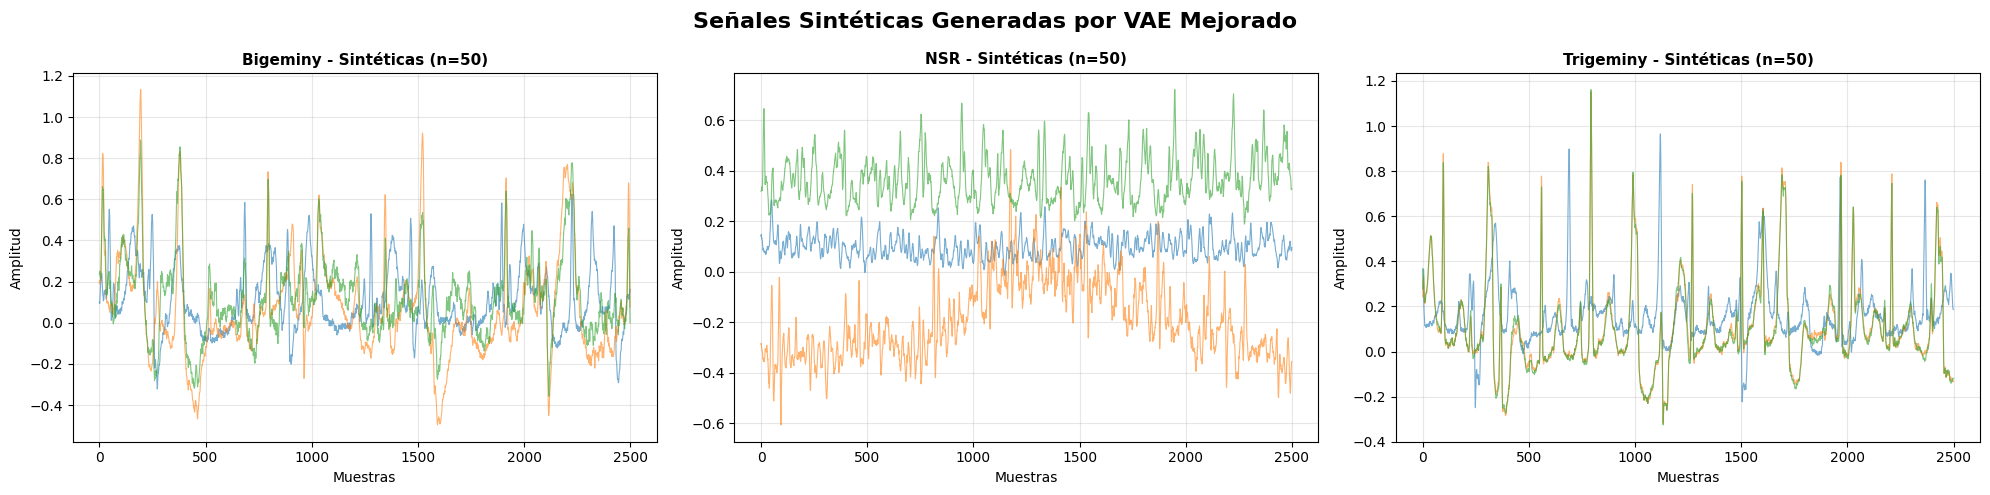

In [49]:
# plot de 5 señales sintéticas generadas de synthetic_df por cada clase, en un axis diferente
# Plot de 5 señales sintéticas generadas de synthetic_df por cada clase, en un axis diferente
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Señales Sintéticas Generadas por VAE Mejorado', fontsize=16, fontweight='bold')

for class_idx, class_name in idx_to_class.items():
    synth_signals = synthetic_df[synthetic_df['target'] == class_name].drop(columns=['target', 'target_idx']).values
    
    ax = axes[class_idx]  # Cambio aquí: solo un índice
    for i in range(3):
        ax.plot(synth_signals[i][:2500], alpha=0.6, linewidth=0.8)
    
    ax.set_title(f'{class_name} - Sintéticas (n={len(synth_signals)})', fontsize=11, fontweight='bold')
    ax.set_xlabel('Muestras', fontsize=10)
    ax.set_ylabel('Amplitud', fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [50]:
# ============= GUARDAR VISUALIZACIÓN DE SEÑALES SINTÉTICAS =============
fig.savefig(f"{output_dir}/03_synthetic_signals_by_class.png", dpi=300, bbox_inches='tight')
print(f"✅ Guardado: {output_dir}/03_synthetic_signals_by_class.png")

✅ Guardado: ../../resultados/imagenes_vae/03_synthetic_signals_by_class.png


## 7. 📊 Visualización de Señales Sintéticas

Visualización de 3 señales sintéticas por clase en gráficos separados para evaluar:
- **Consistencia morfológica**: ¿Las señales mantienen la forma característica?
- **Variabilidad natural**: ¿Hay diversidad suficiente entre las señales generadas?
- **Ausencia de artifacts**: ¿Las señales son suaves y realistas?


EVALUACIÓN DE COHERENCIA MORFOLÓGICA: SEÑALES ORIGINALES vs SINTÉTICAS (synthetic_df)

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
CLASE: BIGEMINY
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

🔍 MÉTRICA 1: CORRELACIÓN DE PEARSON (Similitud de Forma)
   Rango: [-1, 1] | Ideal: > 0.70
   Media:  0.1302 ±  0.2713
   Rango: [-0.1732,  0.9272]

🔍 MÉTRICA 2: DTW DISTANCE (Similitud Temporal Flexible)
   Rango: [0, ∞) | Ideal: < 500
   Media:    0.00 ±    0.00
   Rango: [   0.00,    0.00]

🔍 MÉTRICA 3: SIMILITUD DE PICOS (Morfología de Picos)
   Rango: [0, 1] | Ideal: > 0.80
   Media:  0.8652 ±  0.1072
   Rango: [ 0.5714,  1.0000]

🔍 MÉTRICA 4: COHERENCIA ESPECTRAL (Similitud de Frecuencias)
   Rango: [-1, 1] | Ideal: > 0.70
   Media:  0.7662 ±  0.1126
   Rango: [ 0.3758,  0.9533]

🔍 MÉTRICA 5: RATIO D

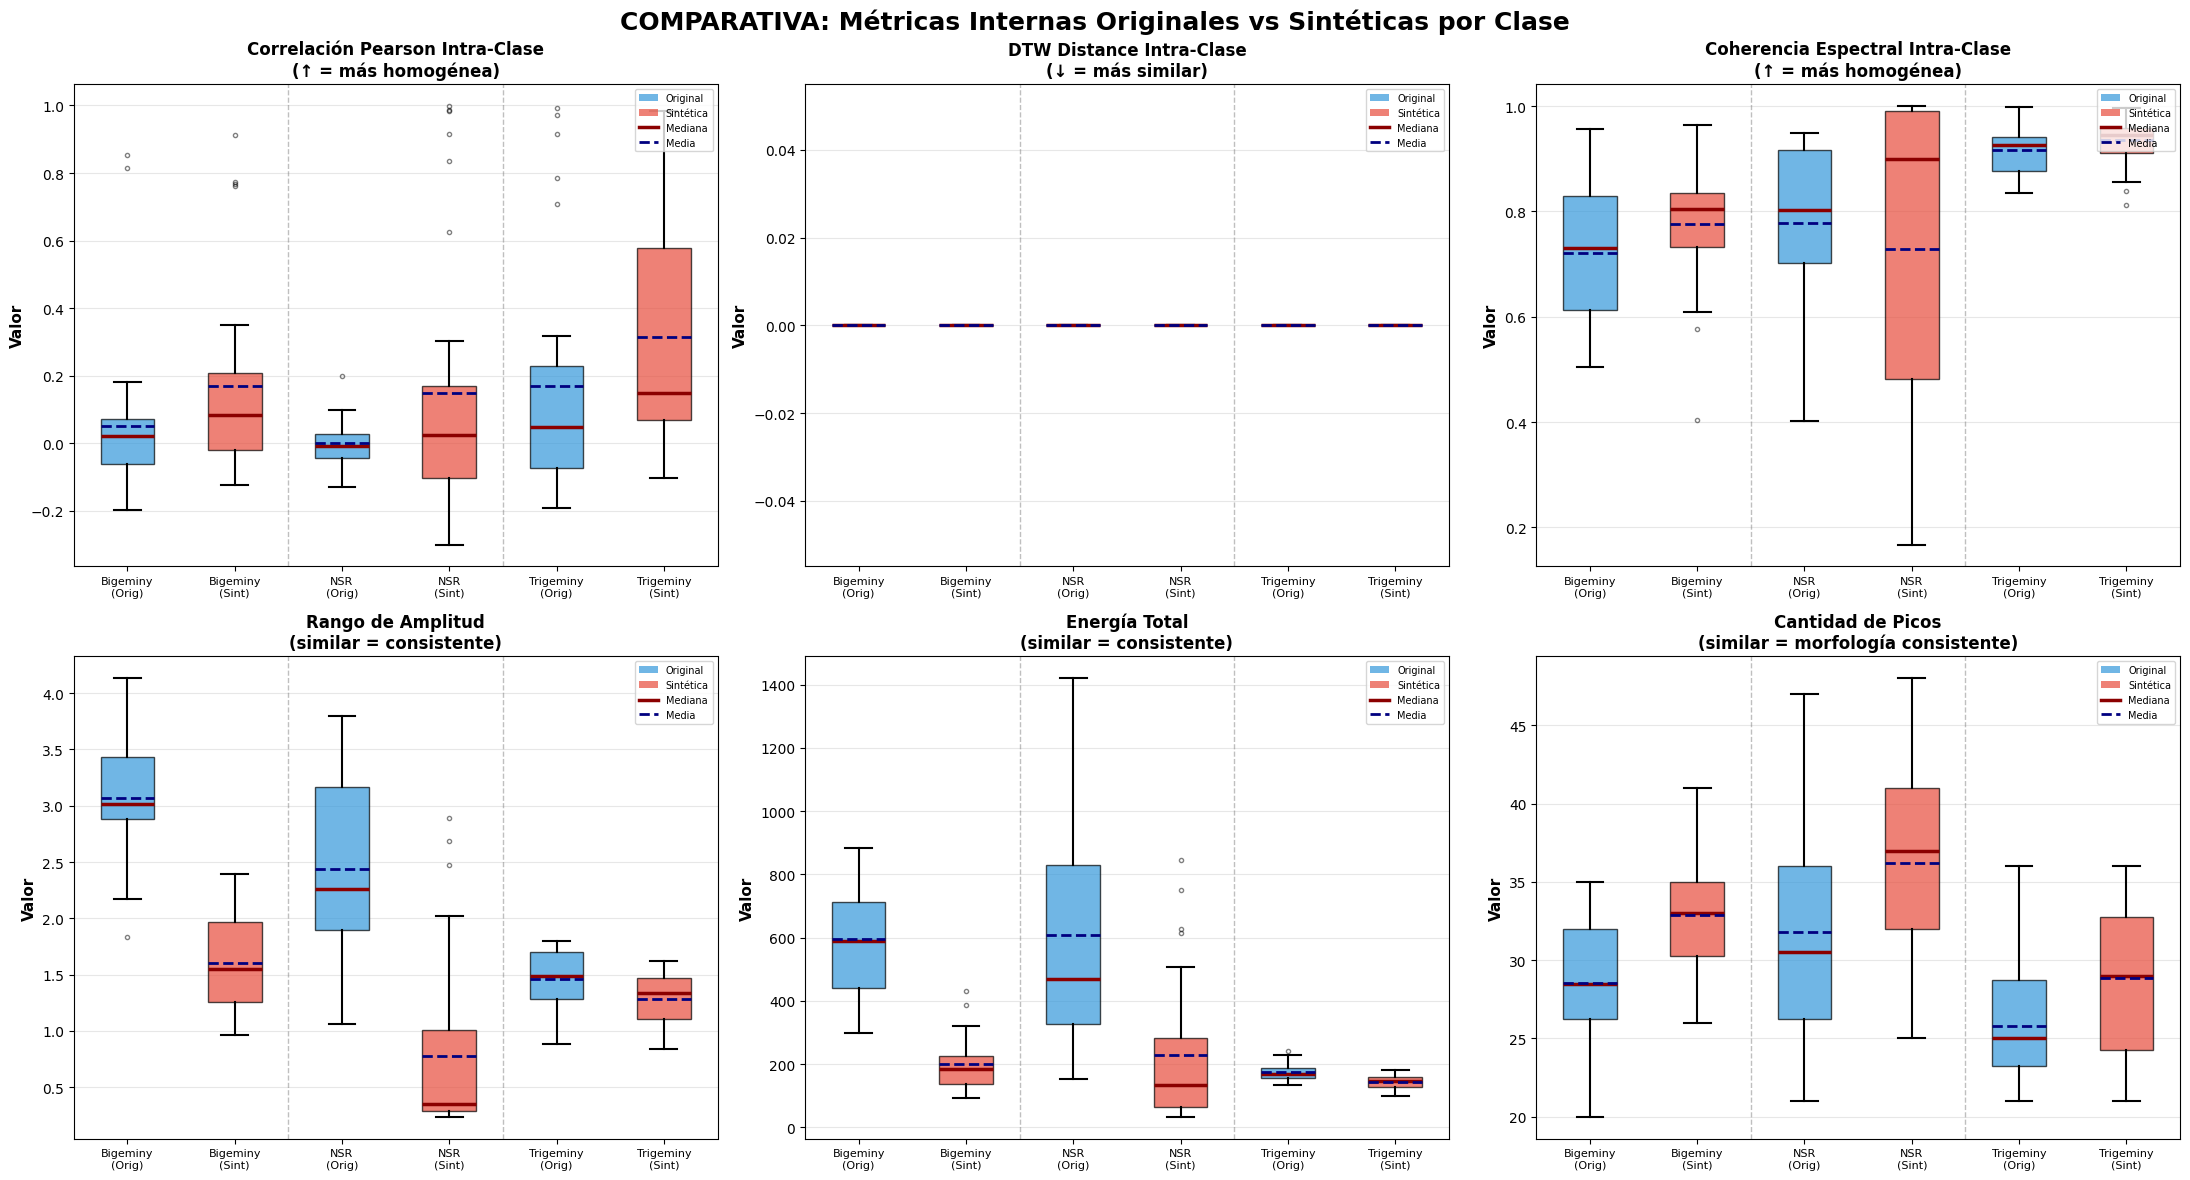


TABLA COMPARATIVA - MÉTRICAS INTERNAS ORIGINALES vs SINTÉTICAS
    Clase      Tipo      Pearson     DTW   Espectral  Amplitud     Energía    Picos
 Bigeminy  Original  0.053±0.230 0.0±0.0 0.721±0.135 3.07±0.51 596.1±164.7 28.6±4.1
 Bigeminy Sintética  0.170±0.277 0.0±0.0 0.776±0.111 1.60±0.38  200.1±78.7 32.9±3.7
      NSR  Original -0.000±0.065 0.0±0.0 0.777±0.164 2.44±0.78 609.5±353.6 31.8±6.6
      NSR Sintética  0.149±0.399 0.0±0.0 0.729±0.302 0.78±0.77 229.5±226.8 36.2±6.2
Trigeminy  Original  0.171±0.343 0.0±0.0 0.916±0.045 1.46±0.26  176.4±26.4 25.8±3.5
Trigeminy Sintética  0.316±0.355 0.0±0.0 0.936±0.044 1.28±0.22  142.9±24.2 28.9±4.7

📊 INTERPRETACIÓN:
   • Si las distribuciones son similares = VAE genera señales con propiedades estadísticas parecidas
   • Pearson alto intra-clase = señales consistentes dentro de cada clase
   • DTW bajo = poca variabilidad temporal dentro de la clase
   • Espectral alto = contenido frecuencial homogéneo
   • Amplitud/Energía/Picos similares 

In [51]:
# ============= MÉTRICAS DE COHERENCIA MORFOLÓGICA =============
from scipy import signal as scipy_signal
from scipy.stats import ks_2samp

def calculate_morphological_metrics(original_df, synthetic_df, class_name):
    """
    Calcula métricas de coherencia morfológica entre señales originales y sintéticas
    """
    # Obtener señales de la clase específica
    orig_class = original_df[original_df['target'] == class_name].drop(columns=['target']).values
    synth_class = synthetic_df[synthetic_df['target'] == class_name].drop(columns=['target', 'target_idx']).values
    
    metrics = {
        'pearson_correlations': [],
        'dtw_distances': [],
        'peak_similarity': [],
        'spectral_coherence': [],
        'amplitude_ratios': [],
        'energy_ratios': [],
        'shape_distances': [],
        'ks_test_pvalues': []
    }
    
    # Comparar múltiples pares de señales
    n_comparisons = min(30, len(synth_class))
    
    for i in range(n_comparisons):
        # Seleccionar una señal sintética y una original aleatoria
        orig_idx = np.random.randint(0, len(orig_class))
        orig = orig_class[orig_idx]
        synth = synth_class[i]
        
        # 1. CORRELACIÓN DE PEARSON (similitud de forma)
        try:
            corr = np.corrcoef(orig, synth)[0, 1]
            metrics['pearson_correlations'].append(corr if not np.isnan(corr) else 0)
        except:
            metrics['pearson_correlations'].append(0)
        
        # 2. DTW DISTANCE (similitud temporal flexible)
        try:
            dtw_dist, _ = fastdtw(orig, synth, dist=euclidean)
            metrics['dtw_distances'].append(dtw_dist)
        except:
            metrics['dtw_distances'].append(np.inf)
        
        # 3. SIMILITUD DE PICOS (morfología de picos)
        try:
            peaks_orig, _ = scipy_signal.find_peaks(orig, distance=50, prominence=0.1)
            peaks_synth, _ = scipy_signal.find_peaks(synth, distance=50, prominence=0.1)
            
            # Comparar número de picos
            if len(peaks_orig) > 0 and len(peaks_synth) > 0:
                peak_ratio = min(len(peaks_orig), len(peaks_synth)) / max(len(peaks_orig), len(peaks_synth))
                metrics['peak_similarity'].append(peak_ratio)
            else:
                metrics['peak_similarity'].append(0)
        except:
            metrics['peak_similarity'].append(0)
        
        # 4. COHERENCIA ESPECTRAL (similitud en frecuencias)
        try:
            fft_orig = np.abs(np.fft.fft(orig))[:len(orig)//2]
            fft_synth = np.abs(np.fft.fft(synth))[:len(synth)//2]
            
            # Normalizar
            fft_orig = fft_orig / (np.max(fft_orig) + 1e-8)
            fft_synth = fft_synth / (np.max(fft_synth) + 1e-8)
            
            # Coherencia espectral
            coherence = np.corrcoef(fft_orig, fft_synth)[0, 1]
            metrics['spectral_coherence'].append(coherence if not np.isnan(coherence) else 0)
        except:
            metrics['spectral_coherence'].append(0)
        
        # 5. RATIO DE AMPLITUD (similitud en rangos)
        try:
            amp_orig = np.max(orig) - np.min(orig)
            amp_synth = np.max(synth) - np.min(synth)
            amp_ratio = min(amp_orig, amp_synth) / max(amp_orig, amp_synth)
            metrics['amplitude_ratios'].append(amp_ratio)
        except:
            metrics['amplitude_ratios'].append(0)
        
        # 6. RATIO DE ENERGÍA
        try:
            energy_orig = np.sum(orig ** 2)
            energy_synth = np.sum(synth ** 2)
            energy_ratio = min(energy_orig, energy_synth) / max(energy_orig, energy_synth)
            metrics['energy_ratios'].append(energy_ratio)
        except:
            metrics['energy_ratios'].append(0)
        
        # 7. DISTANCIA DE FORMA (Frechet)
        try:
            shape_dist = np.max(np.abs(orig - synth))
            metrics['shape_distances'].append(shape_dist)
        except:
            metrics['shape_distances'].append(np.inf)
        
        # 8. TEST DE KOLMOGOROV-SMIRNOV (similitud de distribuciones)
        try:
            ks_stat, p_value = ks_2samp(orig, synth)
            metrics['ks_test_pvalues'].append(p_value)
        except:
            metrics['ks_test_pvalues'].append(0)
    
    # Calcular estadísticas resumidas
    summary = {}
    for metric_name, values in metrics.items():
        valid_values = [v for v in values if not (np.isnan(v) or np.isinf(v))]
        if valid_values:
            summary[metric_name] = {
                'mean': np.mean(valid_values),
                'std': np.std(valid_values),
                'min': np.min(valid_values),
                'max': np.max(valid_values),
                'median': np.median(valid_values)
            }
        else:
            summary[metric_name] = {
                'mean': 0, 'std': 0, 'min': 0, 'max': 0, 'median': 0
            }
    
    return summary

# ============= CALCULAR MÉTRICAS PARA TODAS LAS CLASES =============
print("\n" + "="*140)
print("EVALUACIÓN DE COHERENCIA MORFOLÓGICA: SEÑALES ORIGINALES vs SINTÉTICAS (synthetic_df)")
print("="*140)

morphological_results = {}

for class_idx, class_name in idx_to_class.items():
    print(f"\n{'─'*140}")
    print(f"CLASE: {class_name.upper()}")
    print(f"{'─'*140}")
    
    # Calcular métricas
    metrics = calculate_morphological_metrics(data_resampled, synthetic_df, class_name)
    morphological_results[class_name] = metrics
    
    # Mostrar resultados
    print(f"\n🔍 MÉTRICA 1: CORRELACIÓN DE PEARSON (Similitud de Forma)")
    print(f"   Rango: [-1, 1] | Ideal: > 0.70")
    print(f"   Media: {metrics['pearson_correlations']['mean']:>7.4f} ± {metrics['pearson_correlations']['std']:>7.4f}")
    print(f"   Rango: [{metrics['pearson_correlations']['min']:>7.4f}, {metrics['pearson_correlations']['max']:>7.4f}]")
    
    print(f"\n🔍 MÉTRICA 2: DTW DISTANCE (Similitud Temporal Flexible)")
    print(f"   Rango: [0, ∞) | Ideal: < 500")
    print(f"   Media: {metrics['dtw_distances']['mean']:>7.2f} ± {metrics['dtw_distances']['std']:>7.2f}")
    print(f"   Rango: [{metrics['dtw_distances']['min']:>7.2f}, {metrics['dtw_distances']['max']:>7.2f}]")
    
    print(f"\n🔍 MÉTRICA 3: SIMILITUD DE PICOS (Morfología de Picos)")
    print(f"   Rango: [0, 1] | Ideal: > 0.80")
    print(f"   Media: {metrics['peak_similarity']['mean']:>7.4f} ± {metrics['peak_similarity']['std']:>7.4f}")
    print(f"   Rango: [{metrics['peak_similarity']['min']:>7.4f}, {metrics['peak_similarity']['max']:>7.4f}]")
    
    print(f"\n🔍 MÉTRICA 4: COHERENCIA ESPECTRAL (Similitud de Frecuencias)")
    print(f"   Rango: [-1, 1] | Ideal: > 0.70")
    print(f"   Media: {metrics['spectral_coherence']['mean']:>7.4f} ± {metrics['spectral_coherence']['std']:>7.4f}")
    print(f"   Rango: [{metrics['spectral_coherence']['min']:>7.4f}, {metrics['spectral_coherence']['max']:>7.4f}]")
    
    print(f"\n🔍 MÉTRICA 5: RATIO DE AMPLITUD (Similitud de Rangos)")
    print(f"   Rango: [0, 1] | Ideal: > 0.85")
    print(f"   Media: {metrics['amplitude_ratios']['mean']:>7.4f} ± {metrics['amplitude_ratios']['std']:>7.4f}")
    print(f"   Rango: [{metrics['amplitude_ratios']['min']:>7.4f}, {metrics['amplitude_ratios']['max']:>7.4f}]")
    
    print(f"\n🔍 MÉTRICA 6: RATIO DE ENERGÍA (Similitud de Potencia)")
    print(f"   Rango: [0, 1] | Ideal: > 0.85")
    print(f"   Media: {metrics['energy_ratios']['mean']:>7.4f} ± {metrics['energy_ratios']['std']:>7.4f}")
    print(f"   Rango: [{metrics['energy_ratios']['min']:>7.4f}, {metrics['energy_ratios']['max']:>7.4f}]")
    
    print(f"\n🔍 MÉTRICA 7: DISTANCIA DE FORMA (Máxima Diferencia Punto a Punto)")
    print(f"   Rango: [0, ∞) | Ideal: < 0.50")
    print(f"   Media: {metrics['shape_distances']['mean']:>7.4f} ± {metrics['shape_distances']['std']:>7.4f}")
    print(f"   Rango: [{metrics['shape_distances']['min']:>7.4f}, {metrics['shape_distances']['max']:>7.4f}]")
    
    print(f"\n🔍 MÉTRICA 8: TEST KS (p-value de Similitud de Distribuciones)")
    print(f"   Rango: [0, 1] | Ideal: > 0.05 (no rechaza H0: misma distribución)")
    print(f"   Media: {metrics['ks_test_pvalues']['mean']:>7.4f} ± {metrics['ks_test_pvalues']['std']:>7.4f}")
    print(f"   Rango: [{metrics['ks_test_pvalues']['min']:>7.4f}, {metrics['ks_test_pvalues']['max']:>7.4f}]")

print(f"\n{'='*140}\n")

# ============= COMPARATIVA ORIGINALES VS SINTÉTICAS (MÉTRICAS INTERNAS) =============
def calculate_internal_metrics(signals, n_comparisons=30):
    """
    Calcula métricas internas de un conjunto de señales (comparando entre sí)
    """
    metrics = {
        'pearson': [],
        'dtw': [],
        'spectral': [],
        'amplitude_range': [],
        'energy': [],
        'peak_count': []
    }
    
    n_signals = len(signals)
    n_comparisons = min(n_comparisons, n_signals)
    
    for _ in range(n_comparisons):
        # Seleccionar dos señales aleatorias diferentes
        idx1, idx2 = np.random.choice(n_signals, 2, replace=False)
        sig1 = signals[idx1]
        sig2 = signals[idx2]
        
        # Pearson
        try:
            corr = np.corrcoef(sig1, sig2)[0, 1]
            metrics['pearson'].append(corr if not np.isnan(corr) else 0)
        except:
            metrics['pearson'].append(0)
        
        # DTW
        try:
            dtw_dist, _ = fastdtw(sig1, sig2, dist=euclidean)
            metrics['dtw'].append(dtw_dist)
        except:
            metrics['dtw'].append(0)
        
        # Spectral
        try:
            fft1 = np.abs(np.fft.fft(sig1))[:len(sig1)//2]
            fft2 = np.abs(np.fft.fft(sig2))[:len(sig2)//2]
            fft1 = fft1 / (np.max(fft1) + 1e-8)
            fft2 = fft2 / (np.max(fft2) + 1e-8)
            coherence = np.corrcoef(fft1, fft2)[0, 1]
            metrics['spectral'].append(coherence if not np.isnan(coherence) else 0)
        except:
            metrics['spectral'].append(0)
    
    # Métricas individuales de cada señal
    for sig in signals[:n_comparisons]:
        # Amplitude range
        amp_range = np.max(sig) - np.min(sig)
        metrics['amplitude_range'].append(amp_range)
        
        # Energy
        energy = np.sum(sig ** 2)
        metrics['energy'].append(energy)
        
        # Peak count
        try:
            peaks, _ = scipy_signal.find_peaks(sig, distance=50, prominence=0.1)
            metrics['peak_count'].append(len(peaks))
        except:
            metrics['peak_count'].append(0)
    
    return metrics

# Calcular métricas internas para originales y sintéticas
print("\n" + "="*140)
print("CALCULANDO MÉTRICAS INTERNAS: ORIGINALES vs SINTÉTICAS")
print("="*140)

original_metrics_by_class = {}
synthetic_metrics_by_class = {}

for class_idx, class_name in idx_to_class.items():
    print(f"  Procesando clase: {class_name}...")
    
    # Originales
    orig_class = data_resampled[data_resampled['target'] == class_name].drop(columns=['target']).values
    original_metrics_by_class[class_name] = calculate_internal_metrics(orig_class, n_comparisons=30)
    
    # Sintéticas
    synth_class = synthetic_df[synthetic_df['target'] == class_name].drop(columns=['target', 'target_idx']).values
    synthetic_metrics_by_class[class_name] = calculate_internal_metrics(synth_class, n_comparisons=30)

print("✅ Métricas calculadas\n")

# ============= VISUALIZACIÓN COMPARATIVA (BOX PLOTS LADO A LADO) =============
metric_names_comp = ['pearson', 'dtw', 'spectral', 'amplitude_range', 'energy', 'peak_count']
titles_comp = [
    'Correlación Pearson Intra-Clase\n(↑ = más homogénea)', 
    'DTW Distance Intra-Clase\n(↓ = más similar)', 
    'Coherencia Espectral Intra-Clase\n(↑ = más homogénea)',
    'Rango de Amplitud\n(similar = consistente)', 
    'Energía Total\n(similar = consistente)', 
    'Cantidad de Picos\n(similar = morfología consistente)'
]
colors_comp = ['#2ecc71', '#e74c3c', '#3498db', '#f39c12', '#9b59b6', '#e67e22']

fig, axes = plt.subplots(2, 3, figsize=(22, 12))
fig.suptitle('COMPARATIVA: Métricas Internas Originales vs Sintéticas por Clase', fontsize=18, fontweight='bold')

class_names = list(idx_to_class.values())

for idx, (metric, title, color) in enumerate(zip(metric_names_comp, titles_comp, colors_comp)):
    ax = axes[idx // 3, idx % 3]
    
    # Preparar datos para box plot (Original, Sintética) por cada clase
    data_to_plot = []
    labels_plot = []
    
    for class_name in class_names:
        # Originales
        orig_values = original_metrics_by_class[class_name][metric]
        valid_orig = [v for v in orig_values if not (np.isnan(v) or np.isinf(v))]
        data_to_plot.append(valid_orig if valid_orig else [0])
        labels_plot.append(f'{class_name}\n(Orig)')
        
        # Sintéticas
        synth_values = synthetic_metrics_by_class[class_name][metric]
        valid_synth = [v for v in synth_values if not (np.isnan(v) or np.isinf(v))]
        data_to_plot.append(valid_synth if valid_synth else [0])
        labels_plot.append(f'{class_name}\n(Sint)')
    
    # Crear box plot con colores alternados
    positions = list(range(len(data_to_plot)))
    bp = ax.boxplot(data_to_plot, positions=positions, patch_artist=True,
                     widths=0.5, showmeans=True, meanline=True,
                     medianprops=dict(color='darkred', linewidth=2.5),
                     meanprops=dict(color='navy', linewidth=2, linestyle='--'),
                     whiskerprops=dict(linewidth=1.5),
                     capprops=dict(linewidth=1.5),
                     flierprops=dict(marker='o', markersize=3, alpha=0.5))
    
    # Colorear cajas alternadamente (original vs sintética)
    for patch_idx, patch in enumerate(bp['boxes']):
        if patch_idx % 2 == 0:  # Original
            patch.set_facecolor('#3498db')
            patch.set_alpha(0.7)
        else:  # Sintética
            patch.set_facecolor('#e74c3c')
            patch.set_alpha(0.7)
    
    ax.set_xticks(positions)
    ax.set_xticklabels(labels_plot, fontsize=8, rotation=0)
    ax.set_ylabel('Valor', fontsize=11, fontweight='bold')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Agregar separadores verticales entre clases
    for i in range(1, len(class_names)):
        ax.axvline(x=i*2 - 0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    
    # Leyenda
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#3498db', alpha=0.7, label='Original'),
        Patch(facecolor='#e74c3c', alpha=0.7, label='Sintética'),
        ax.plot([], [], color='darkred', linewidth=2.5, label='Mediana')[0],
        ax.plot([], [], color='navy', linewidth=2, linestyle='--', label='Media')[0]
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=7)

plt.tight_layout()
plt.show()

# ============= TABLA COMPARATIVA RESUMEN =============
print("\n" + "="*160)
print("TABLA COMPARATIVA - MÉTRICAS INTERNAS ORIGINALES vs SINTÉTICAS")
print("="*160)

comparison_data = []
for class_name in class_names:
    for data_type, metrics_dict in [('Original', original_metrics_by_class), ('Sintética', synthetic_metrics_by_class)]:
        row = {
            'Clase': class_name,
            'Tipo': data_type,
            'Pearson': f"{np.mean(metrics_dict[class_name]['pearson']):.3f}±{np.std(metrics_dict[class_name]['pearson']):.3f}",
            'DTW': f"{np.mean(metrics_dict[class_name]['dtw']):.1f}±{np.std(metrics_dict[class_name]['dtw']):.1f}",
            'Espectral': f"{np.mean(metrics_dict[class_name]['spectral']):.3f}±{np.std(metrics_dict[class_name]['spectral']):.3f}",
            'Amplitud': f"{np.mean(metrics_dict[class_name]['amplitude_range']):.2f}±{np.std(metrics_dict[class_name]['amplitude_range']):.2f}",
            'Energía': f"{np.mean(metrics_dict[class_name]['energy']):.1f}±{np.std(metrics_dict[class_name]['energy']):.1f}",
            'Picos': f"{np.mean(metrics_dict[class_name]['peak_count']):.1f}±{np.std(metrics_dict[class_name]['peak_count']):.1f}"
        }
        comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))
print("="*160)

print("\n📊 INTERPRETACIÓN:")
print("   • Si las distribuciones son similares = VAE genera señales con propiedades estadísticas parecidas")
print("   • Pearson alto intra-clase = señales consistentes dentro de cada clase")
print("   • DTW bajo = poca variabilidad temporal dentro de la clase")
print("   • Espectral alto = contenido frecuencial homogéneo")
print("   • Amplitud/Energía/Picos similares = morfología consistente")
print("\n✅ COMPARATIVA COMPLETADA")

# ============= TABLA RESUMEN CONSOLIDADA =============
print("\n" + "="*160)
print("TABLA RESUMEN - MÉTRICAS DE COHERENCIA MORFOLÓGICA")
print("="*160)

summary_data = []
for class_name in morphological_results.keys():
    row = {'Clase': class_name}
    metrics_dict = morphological_results[class_name]
    
    row['Pearson (↑)'] = f"{metrics_dict['pearson_correlations']['mean']:.3f}±{metrics_dict['pearson_correlations']['std']:.3f}"
    row['DTW (↓)'] = f"{metrics_dict['dtw_distances']['mean']:.1f}±{metrics_dict['dtw_distances']['std']:.1f}"
    row['Picos (↑)'] = f"{metrics_dict['peak_similarity']['mean']:.3f}±{metrics_dict['peak_similarity']['std']:.3f}"
    row['Espectral (↑)'] = f"{metrics_dict['spectral_coherence']['mean']:.3f}±{metrics_dict['spectral_coherence']['std']:.3f}"
    row['Amplitud (↑)'] = f"{metrics_dict['amplitude_ratios']['mean']:.3f}±{metrics_dict['amplitude_ratios']['std']:.3f}"
    row['Energía (↑)'] = f"{metrics_dict['energy_ratios']['mean']:.3f}±{metrics_dict['energy_ratios']['std']:.3f}"
    row['Forma (↓)'] = f"{metrics_dict['shape_distances']['mean']:.3f}±{metrics_dict['shape_distances']['std']:.3f}"
    row['KS p-val (↑)'] = f"{metrics_dict['ks_test_pvalues']['mean']:.3f}±{metrics_dict['ks_test_pvalues']['std']:.3f}"
    
    summary_data.append(row)

summary_df_morph = pd.DataFrame(summary_data)
print(summary_df_morph.to_string(index=False))
print("="*160)

print("\n📋 INTERPRETACIÓN DE MÉTRICAS:")
print("   1. Pearson: Similitud en patrones (ideal: > 0.70)")
print("   2. DTW: Distancia temporal flexible (ideal: < 500)")
print("   3. Picos: Similitud en morfología de picos (ideal: > 0.80)")
print("   4. Espectral: Coherencia en frecuencias (ideal: > 0.70)")
print("   5. Amplitud: Ratio de rangos (ideal: > 0.85)")
print("   6. Energía: Ratio de potencia (ideal: > 0.85)")
print("   7. Forma: Máxima diferencia punto-punto (ideal: < 0.50)")
print("   8. KS Test: p-value de distribución (ideal: > 0.05 = misma distribución)")
print("\n✅ EVALUACIÓN COMPLETA")


In [52]:
# ============= GUARDAR BOX PLOTS COMPARATIVOS =============
fig.savefig(f"{output_dir}/04_boxplots_internal_metrics.png", dpi=300, bbox_inches='tight')
print(f"✅ Guardado: {output_dir}/04_boxplots_internal_metrics.png")

✅ Guardado: ../../resultados/imagenes_vae/04_boxplots_internal_metrics.png
